## Copy this notebook (if using Colab) via `File -> Save a Copy in Drive`.

## You can do this assignment outside of Colab (using your local Python installation) via `File -> Download`.

## <u>**Use the "Text" blocks to provide explanations wherever you find them necessary. Highlight your answers inside these text fields to ensure that we don't miss it while grading your HW.**</u>

## **Setup**

- Code to download the data directly from the colab notebook.
- If you find it easier to download the data from the kaggle website (and uploading it to your drive), you can skip this section.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# First mount your drive before running these cells.
# Create a folder for the this HW and change to that dir
%cd drive/MyDrive/CSE519

/content/drive/MyDrive/CSE519


# Download data from Kaggle

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
# Create a new API token under "Account" in the kaggle webpage and download the json file
# Upload the file by clicking on the browse
files.upload()

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle competitions download -c commonlit-evaluate-student-summaries

# Alternate: download data using gdown (if having issues with Kaggle)

In [ ]:
!pip install gdown

In [ ]:
import gdown
url = 'https://drive.google.com/uc?id=164sQHZYvxU2XXPokrjzqv9MCGAMHaCIM'
gdown.download(url)

# Extract data and install packages (regardless of data acquisition method)

In [ ]:
!unzip commonlit-evaluate-student-summaries.zip

In [4]:
### TODO: Install required packages
### Student's code here
!pip install pandas
!pip install scikit-learn
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install textstat
### END

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 11.2 MB/s eta 0:00:00


## **Section 1: Library and Data Imports (Q1, 5 points)**

- Import your libraries and join the data from both `summaries_train.csv` and `prompts_train.csv` into a single dataframe with the same structure as `use_cols`. Print the head of the dataframe. **Do not modify `use_cols`.**

In [5]:
### TODO: Load required packages
### Student's code here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
import string
import spacy
import  textstat
from sklearn.feature_extraction.text import TfidfVectorizer
#import language_check
###

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
use_cols = ["student_id",
            "prompt_id",
            "text",
            "content",
            "wording",
            "prompt_question",
            "prompt_title",
            "prompt_text"
           ]
dtypes = {
        'student_id':                                    'string',
        'prompt_id':                                     'string',
        'text':                                          'string',
        'content':                                       'Float64',
        'wording':                                       'Float64',
        'prompt_question':                               'string',
        'prompt_title':                                  'string',
        'prompt_text':                                   'string',
        }

In [8]:
#loading csv to dataframes

summaries_train_path = r'/content/drive/MyDrive/CSE519/summaries_train.csv'
prompts_train_path = r'/content/drive/MyDrive/CSE519/prompts_train.csv'
summaries_train = pd.read_csv(summaries_train_path)
prompts_train = pd.read_csv(prompts_train_path)





In [9]:
#merging the two given dataframes
merged_train = pd.merge(summaries_train, prompts_train, on='prompt_id', how = 'left')
temp_2df = merged_train.copy()
merged_train = merged_train.astype(dtypes)

In [10]:
merged_train.head()

,student_id,prompt_id,text,content,wording,prompt_question,prompt_title,prompt_text
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background The Third Wave experiment took pl...
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an..."
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,Summarize how the Third Wave developed over su...,The Third Wave,Background The Third Wave experiment took pl...


In [11]:
#checking types for merged dataframe
merged_train.dtypes

student_id          string
prompt_id           string
text                string
content            Float64
wording            Float64
prompt_question     string
prompt_title        string
prompt_text         string
dtype: object

## **Section 2: Features (Q2 and Q3, 25 points total)**

In [12]:
#creating 5 given features
def countofwords(text):
  return len(re.findall(r'\w+', text))

def distinctwords(text):
  return len(set(re.findall(r'\w+', text)))

def commonwords(text1, text2):
  text1 = text1.lower()
  text2 = text2.lower()
  t1 , t2 = re.findall(r'\w+', text1), re.findall(r'\w+', text2)
  return len(list(set(t1) & set(t2)))



In [13]:
#additional features
def count_stopwords(text):
    stopword_list = set(stopwords.words('english'))
    words = re.findall(r'\w+', text)
    stopwords_count = sum(1 for ele in words if ele.lower() in stopword_list)
    return stopwords_count
def count_punctuation(text):

    punctuation_count = sum(1 for punc in text if punc in set(string.punctuation))
    return punctuation_count

In [14]:
#adding all the created features(for Q2) to the merged dataframe
merged_train["words_in_text"] = merged_train.apply(lambda x: countofwords(x['text']), axis = 1)
merged_train["words_in_prompt_text"] = merged_train.apply(lambda x: countofwords(x['prompt_text']), axis = 1)
merged_train["distinct_words_in_text"] = merged_train.apply(lambda x: distinctwords(x['text']), axis = 1)
merged_train["distinct_words_in_prompt_text"] = merged_train.apply(lambda x: distinctwords(x['prompt_text']), axis = 1)
merged_train["common_words_in_text_and_prompt_text"] = merged_train.apply(lambda x: commonwords(x['text'],x['prompt_text']), axis = 1)
merged_train["common_words_in_text_and_prompt_question"] = merged_train.apply(lambda x: commonwords(x['text'],x['prompt_question']), axis = 1)
merged_train["common_words_in_text_and_prompt_title"] = merged_train.apply(lambda x: commonwords(x['text'],x['prompt_title']), axis = 1)
merged_train.head()

,student_id,prompt_id,text,content,wording,prompt_question,prompt_title,prompt_text,words_in_text,words_in_prompt_text,distinct_words_in_text,distinct_words_in_prompt_text,common_words_in_text_and_prompt_text,common_words_in_text_and_prompt_question,common_words_in_text_and_prompt_title
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background The Third Wave experiment took pl...,61,601,51,280,24,7,3
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an...",52,977,36,384,33,5,1
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,239,556,146,303,81,10,1
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,28,556,22,303,15,2,0
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,Summarize how the Third Wave developed over su...,The Third Wave,Background The Third Wave experiment took pl...,205,601,133,280,53,10,3


## **Section 3: Content and Wording (Q4, 10 points)**

# List of Functions:


*   f1: Ratio of stopping and total words in text
*   f2: average sentence length in text


*   f3: readability score metric for text
*   f4: pollysyllable count per word in text

*   f5: average word length in text








In [15]:
def ratio_of_stopping_words(text):
  total_words_in_text = countofwords(text)
  stopping_words_in_text = count_stopwords(text)
  return (total_words_in_text / stopping_words_in_text)


# using textstat library  - https://pypi.org/project/textstat/
def average_sentence_length(text):
  sentence_count = textstat.sentence_count(text)
  word_count = countofwords(text)
  return word_count / sentence_count


# using textstat library to get the flesch reading ease score
# Smog reading score. https://en.wikipedia.org/wiki/SMOG
def readibility_score(text):
  return textstat.smog_index(text)


# counting the no. of polysyllable words in the text
def polysyllable_count_perwords(text):
  word_count = countofwords(text)
  return textstat.polysyllabcount(text) / word_count


#using text stat library to count no. of chars in the essay. Letter_count: Returns the number of characters present in the given text without punctuation.
def avg_word_length(text):
  word_count = countofwords(text)
  total_chars=  textstat.letter_count(text, ignore_spaces=True)
  return total_chars/word_count

In [16]:
merged_train["ratio_of_stopping_words"] = merged_train.apply(lambda x: ratio_of_stopping_words(x['text']), axis = 1)
merged_train["average_sentence_length"] = merged_train.apply(lambda x: average_sentence_length(x['text']), axis = 1)
merged_train["readibility_score"] = merged_train.apply(lambda x: readibility_score(x['text']), axis = 1)
merged_train["polysyllable_count_perwords"] = merged_train.apply(lambda x: polysyllable_count_perwords(x['text']), axis = 1)
merged_train["avg_word_length"] = merged_train.apply(lambda x: avg_word_length(x['text']), axis = 1)

In [17]:
merged_train.head()

,student_id,prompt_id,text,content,wording,prompt_question,prompt_title,prompt_text,words_in_text,words_in_prompt_text,distinct_words_in_text,distinct_words_in_prompt_text,common_words_in_text_and_prompt_text,common_words_in_text_and_prompt_question,common_words_in_text_and_prompt_title,ratio_of_stopping_words,average_sentence_length,readibility_score,polysyllable_count_perwords,avg_word_length
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background The Third Wave experiment took pl...,61,601,51,280,24,7,3,2.440000,15.250000,10.7,0.114754,4.639344
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an...",52,977,36,384,33,5,1,1.677419,26.000000,0.0,0.000000,3.673077
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,239,556,146,303,81,10,1,2.276190,19.916667,9.3,0.058577,4.594142
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,28,556,22,303,15,2,0,2.333333,9.333333,9.7,0.142857,4.535714
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,Summarize how the Third Wave developed over su...,The Third Wave,Background The Third Wave experiment took pl...,205,601,133,280,53,10,3,2.135417,14.642857,10.1,0.102439,4.829268


## **Section 4: Words in Good and Bad Essays (Q5, 10 points)**

# Calculating quartile based on wording and content scores.
To categorize essays as bad and good


Good essay = total_score >= 6 ;


bad essay = total_score <= 4

The scores are calculated based on which quartile they lie in for wording and content scores. Hence, quartile is an appropriate metric in my opinion.

The words are the output of the below code block.



In [18]:
#creating copy df to compute the quartile values and summing those values to compute the total score.
quartile_df = merged_train.copy()
quartile_df['wording_score'] = pd.qcut(quartile_df['wording'], 4, labels = [1,2,3,4])
quartile_df['content_score'] = pd.qcut(quartile_df['content'], 4, labels = [1,2,3,4])
quartile_df.drop(quartile_df.columns[range(8,20)], axis=1, inplace=True)
quartile_df[['wording_score', 'content_score']] = quartile_df[['wording_score', 'content_score']].apply(pd.to_numeric)
quartile_df['total_score'] = quartile_df['wording_score'] + quartile_df['content_score']




good_essays = quartile_df[quartile_df['total_score'] >= 6]['text']
bad_essays = quartile_df[quartile_df['total_score'] <= 4]['text']

def preprocess_text(text):

    words = nltk.word_tokenize(text.lower())

    # Remove stopwords and non-alphabetic words
    words = [word for word in words if word.isalpha() and word not in stopwords.words("english")]

    # Join the cleaned words back into a text
    return " ".join(words)

good_essays = good_essays.apply(preprocess_text)
bad_essays = bad_essays.apply(preprocess_text)

tfidf_good = TfidfVectorizer()
tfidf_bad = TfidfVectorizer()

tfidf_good_matrix = tfidf_good.fit_transform(good_essays)
tfidf_bad_matrix = tfidf_bad.fit_transform(bad_essays)
tfidf_good_df = pd.DataFrame(tfidf_good_matrix.toarray(), columns=tfidf_good.get_feature_names_out())
tfidf_bad_df = pd.DataFrame(tfidf_bad_matrix.toarray(), columns=tfidf_bad.get_feature_names_out())

#mean scores for TF-IDF score of all the words in both type of essays
mean_tfidf_good = tfidf_good_df.mean()
mean_tfidf_bad = tfidf_bad_df.mean()

#calculating tfidf diff in good and bad for each word so that they match what is required in the question
tfidf_diff = mean_tfidf_good - mean_tfidf_bad

overrepresented_good = tfidf_diff[tfidf_diff > 0].sort_values(ascending=False)

disproportionate_bad = tfidf_diff[tfidf_diff < 0].sort_values(ascending=True)

# I have taken top 10 words each for, overrepresented in good essays and dispoportionate in bad essays
print("Words over-represented in good essays:")
print(overrepresented_good.head(10),end=" ")
print("\n Words disproportionately in bad essays:")
print(disproportionate_bad.head(10), end=" ")




Words over-represented in good essays:
students      0.023833
experiment    0.014708
jones         0.014312
meat          0.012370
farmers       0.011836
nobles        0.011440
element       0.011207
third         0.010472
people        0.010306
class         0.010217
dtype: float64 
 Words disproportionately in bad essays:
plan      -0.008408
complex   -0.008383
imitate   -0.007786
else      -0.007660
excite    -0.007321
fear      -0.006714
actions   -0.006312
pity      -0.006203
chop      -0.006185
rub       -0.006084
dtype: float64 

# Exploring the distributions of scores for content and wording as histograms to figure out the range and if they are correlated.

/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:499: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges, name="edges"),
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:500: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(widths, name="widths"),
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:499: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges, name="edges"),
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:500: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(widths, 

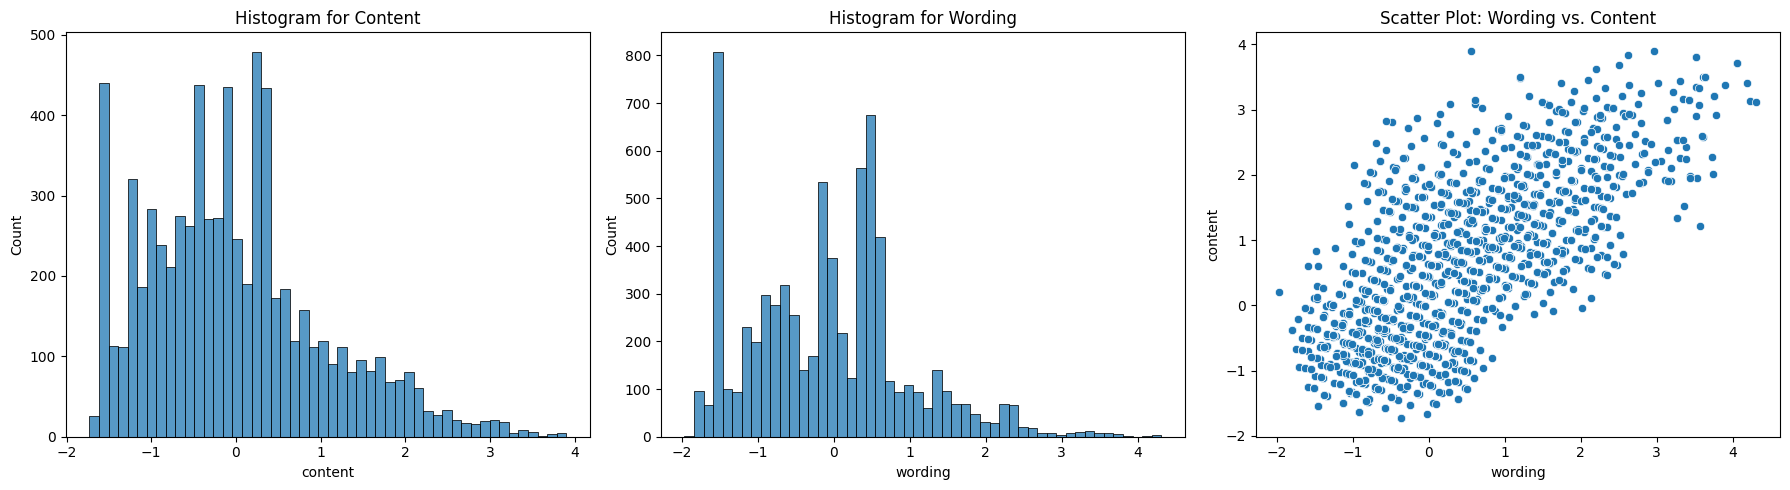

In [19]:
# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1 row, 3 columns

# Plot 1: Histogram for 'content'
sns.histplot(data=merged_train['content'], bins=50, ax=axes[0])
axes[0].set_title('Histogram for Content')

# Plot 2: Histogram for 'wording'
sns.histplot(data=merged_train['wording'], bins=50, ax=axes[1])
axes[1].set_title('Histogram for Wording')

# Plot 3: Scatter plot
sns.scatterplot(data=merged_train, x="wording", y="content", ax=axes[2])
axes[2].set_title('Scatter Plot: Wording vs. Content')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

# Range of values:


1.   For content, the range will be the height of the plot. which can be computed by by subtracting the lowest y cordinate value from the highest y cordinate value of the plot.
2.   For wording, the range will be the width of the plot. which can be calculated by subtracting the lowest x cordinate value from the highest x cordinate value of the plot.  




# Correlation


1.   They(wording and content) are moderately positively correlated since both the values are increasing together.



/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:499: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges, name="edges"),
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:500: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(widths, name="widths"),
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:499: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges, name="edges"),
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:500: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(widths, 

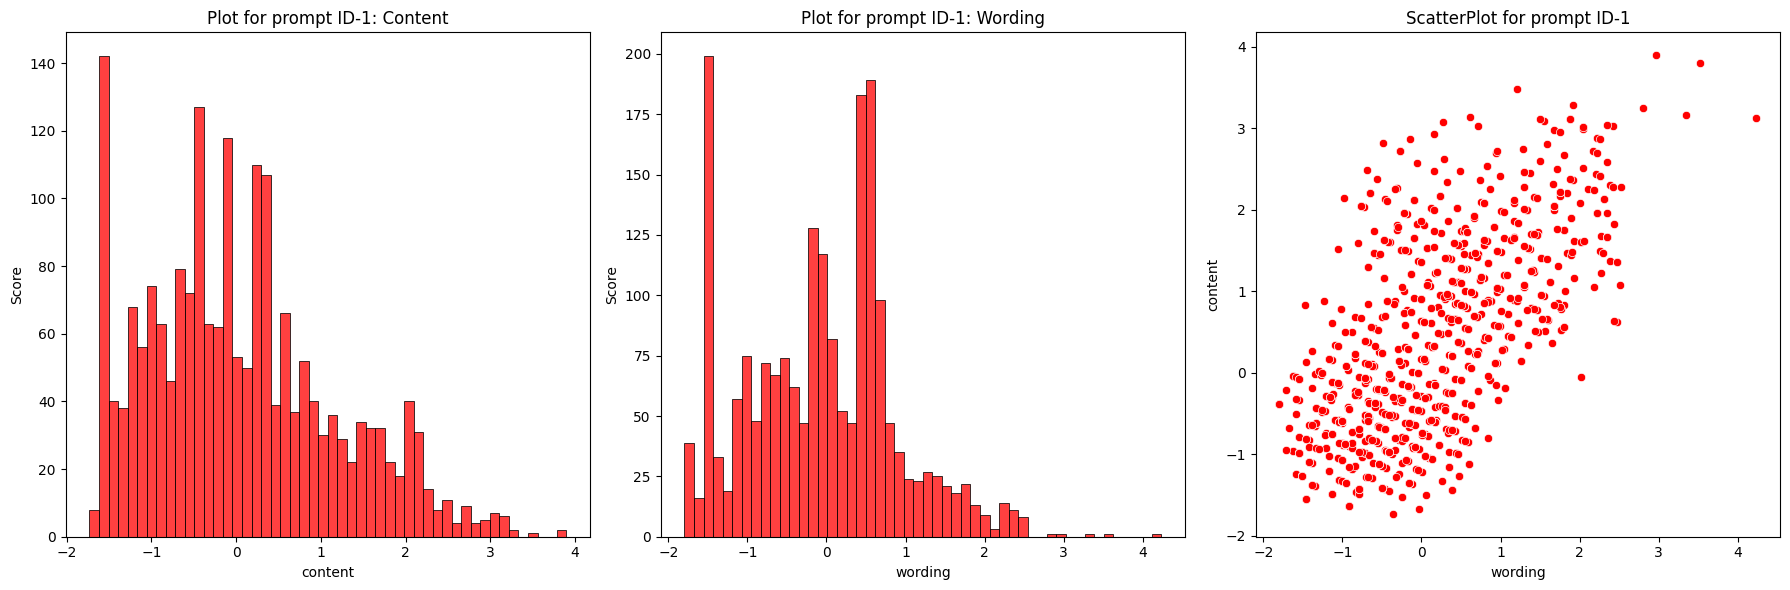

In [20]:
df1 = merged_train[merged_train["prompt_id"].str.contains("3b9047")]
plt.figure(figsize=(18, 6))

# First subplot: Histogram for Content
plt.subplot(131)
sns.histplot(data=df1['content'], bins=50, color='red')
plt.title("Plot for prompt ID-1: Content")
plt.ylabel('Score')

# Second subplot: Histogram for Wording
plt.subplot(132)
sns.histplot(data=df1['wording'], bins=50, color='red')
plt.title("Plot for prompt ID-1: Wording")
plt.ylabel('Score')

# Third subplot: ScatterPlot
plt.subplot(133)
sns.scatterplot(data=df1, x="wording", y="content", color='red')
plt.title("ScatterPlot for prompt ID-1")

# Adjust the layout
plt.tight_layout()

# Show the composite figure
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:499: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges, name="edges"),
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:500: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(widths, name="widths"),
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:499: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges, name="edges"),
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:500: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(widths, 

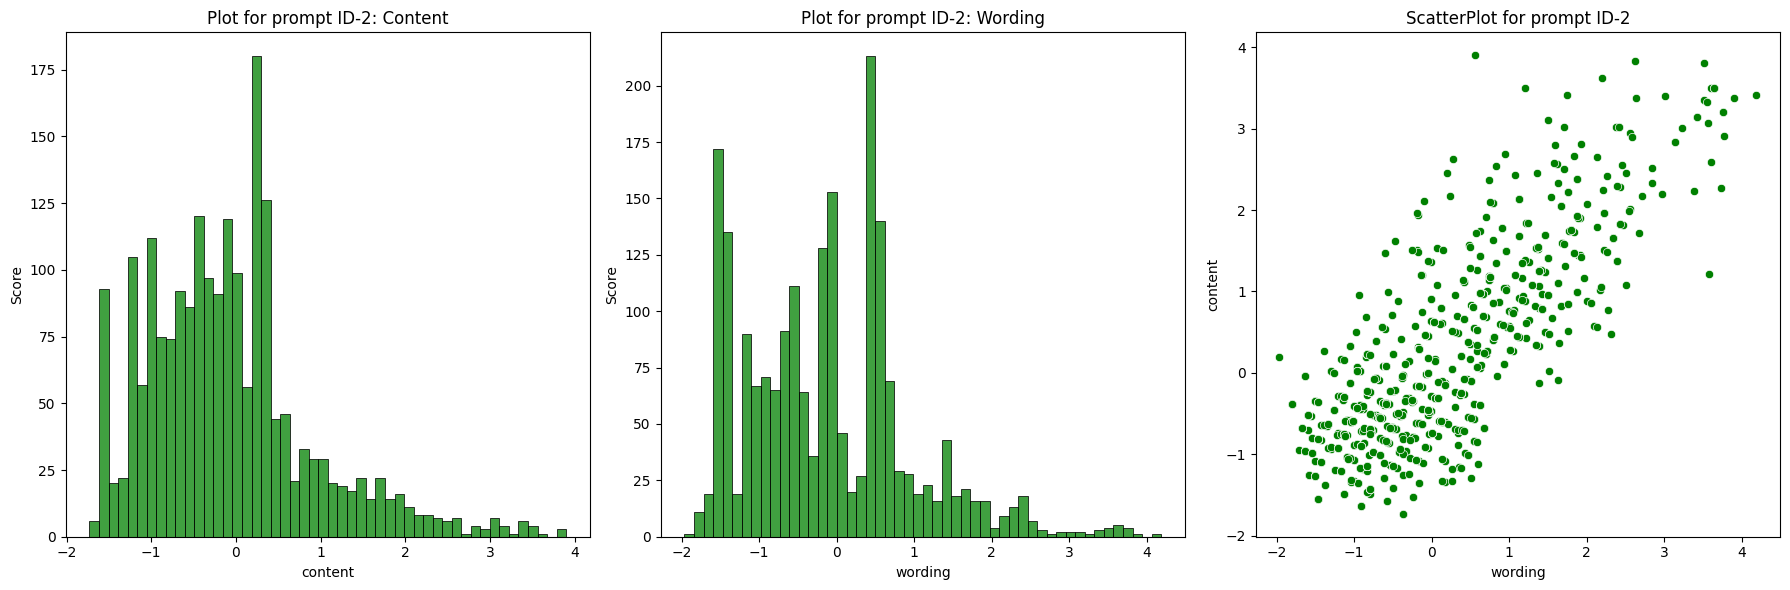

In [21]:
df2 = merged_train[merged_train["prompt_id"].str.contains("39c16e")]
plt.figure(figsize=(18, 6))

# First subplot: Histogram for Content
plt.subplot(131)
sns.histplot(data=df2['content'], bins=50, color='green')
plt.title("Plot for prompt ID-2: Content")
plt.ylabel('Score')

# Second subplot: Histogram for Wording
plt.subplot(132)
sns.histplot(data=df2['wording'], bins=50, color='green')
plt.title("Plot for prompt ID-2: Wording")
plt.ylabel('Score')

# Third subplot: ScatterPlot
plt.subplot(133)
sns.scatterplot(data=df2, x="wording", y="content", color='green')
plt.title("ScatterPlot for prompt ID-2")

# Adjust the layout
plt.tight_layout()

# Show the composite figure
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:499: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges, name="edges"),
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:500: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(widths, name="widths"),
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:499: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges, name="edges"),
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:500: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(widths, 

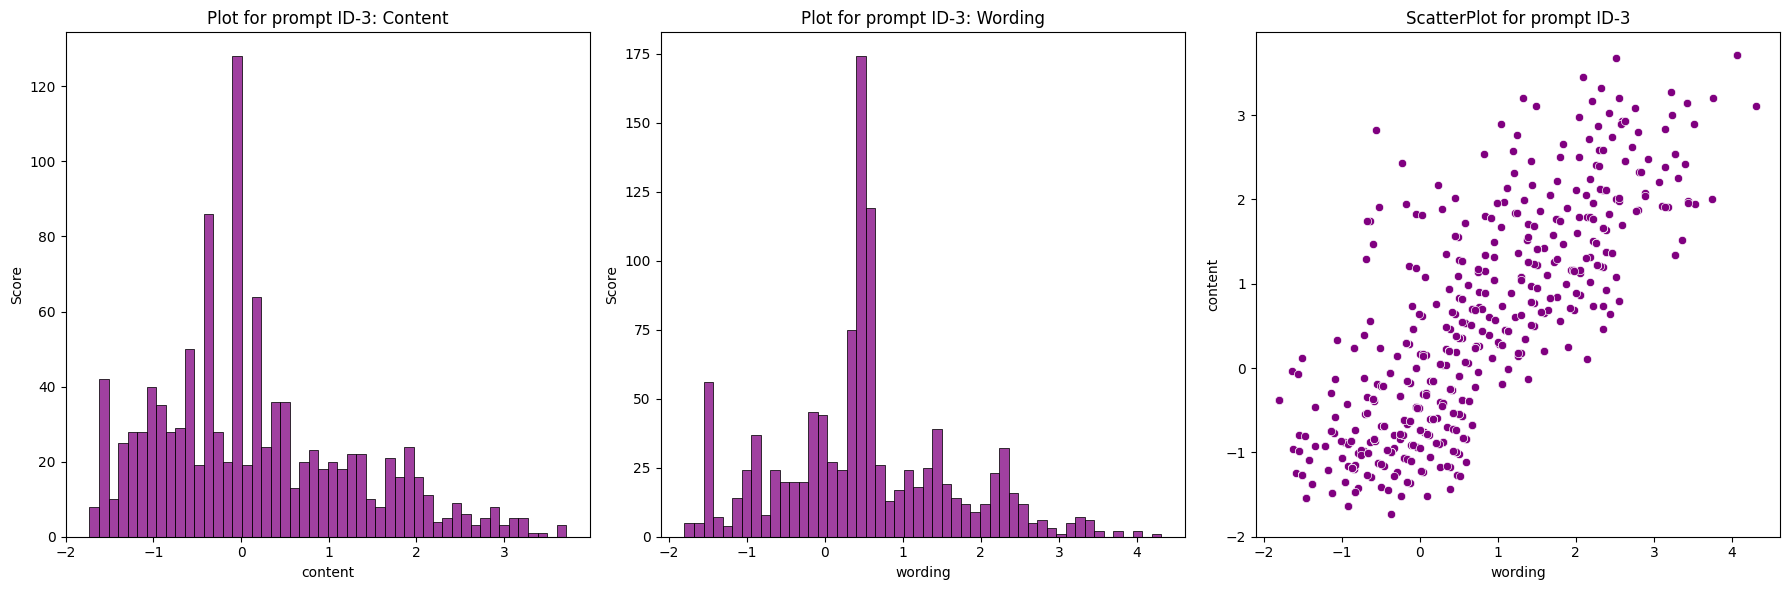

In [22]:
df3 = merged_train[merged_train["prompt_id"].str.contains("814d6b")]
plt.figure(figsize=(18, 6))

# First subplot: Histogram for Content
plt.subplot(131)
sns.histplot(data=df3['content'], bins=50, color='purple')
plt.title("Plot for prompt ID-3: Content")
plt.ylabel('Score')

# Second subplot: Histogram for Wording
plt.subplot(132)
sns.histplot(data=df3['wording'], bins=50, color='purple')
plt.title("Plot for prompt ID-3: Wording")
plt.ylabel('Score')

# Third subplot: ScatterPlot
plt.subplot(133)
sns.scatterplot(data=df3, x="wording", y="content", color='purple')
plt.title("ScatterPlot for prompt ID-3")

# Adjust the layout
plt.tight_layout()

# Show the composite figure
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:499: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges, name="edges"),
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:500: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(widths, name="widths"),
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:499: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges, name="edges"),
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:500: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(widths, 

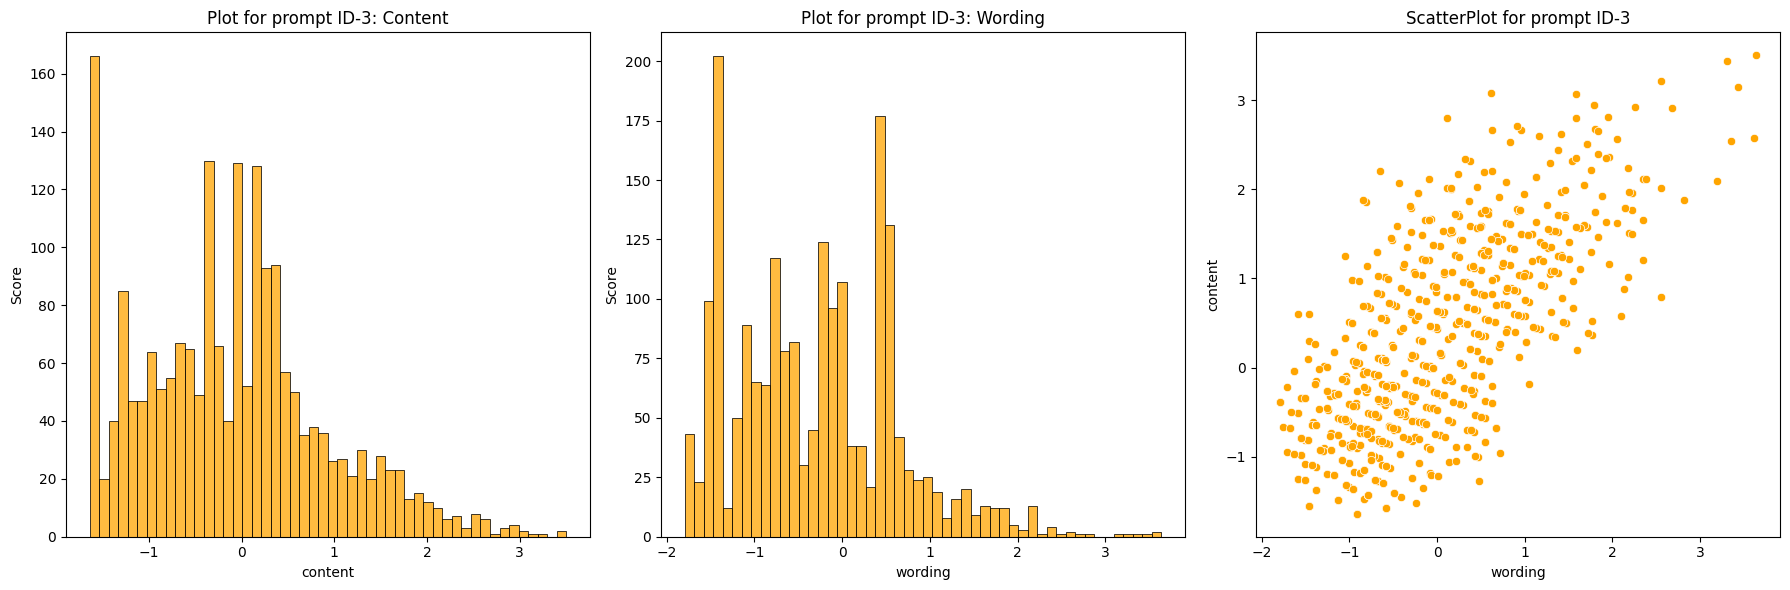

In [23]:
df4 = merged_train[merged_train["prompt_id"].str.contains("ebad26")]
plt.figure(figsize=(18, 6))

# First subplot: Histogram for Content
plt.subplot(131)
sns.histplot(data=df4['content'], bins=50, color='orange')
plt.title("Plot for prompt ID-3: Content")
plt.ylabel('Score')

# Second subplot: Histogram for Wording
plt.subplot(132)
sns.histplot(data=df4['wording'], bins=50, color='orange')
plt.title("Plot for prompt ID-3: Wording")
plt.ylabel('Score')

# Third subplot: ScatterPlot
plt.subplot(133)
sns.scatterplot(data=df4, x="wording", y="content", color='orange')
plt.title("ScatterPlot for prompt ID-3")

# Adjust the layout
plt.tight_layout()

# Show the composite figure
plt.show()

No, the plots for different prompts do not differ from the total plot.

In [24]:
quartile_df.head()

,student_id,prompt_id,text,content,wording,prompt_question,prompt_title,prompt_text,wording_score,content_score,total_score
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background The Third Wave experiment took pl...,3,3,6
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an...",4,2,6
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,4,4,8
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,2,2,4
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,Summarize how the Third Wave developed over su...,The Third Wave,Background The Third Wave experiment took pl...,4,4,8


## **Section 5: Three Interesting Plots (Q6, 15 points)**


# I have made the 3rd plot for this question at the end after using a model.

Dataframe used for plotting

In [27]:
# Plotting df

plot_df = merged_train.copy()

plot_df.head()

,student_id,prompt_id,text,content,wording,prompt_question,prompt_title,prompt_text,words_in_text,words_in_prompt_text,distinct_words_in_text,distinct_words_in_prompt_text,common_words_in_text_and_prompt_text,common_words_in_text_and_prompt_question,common_words_in_text_and_prompt_title,ratio_of_stopping_words,average_sentence_length,readibility_score,polysyllable_count_perwords,avg_word_length
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background The Third Wave experiment took pl...,61,601,51,280,24,7,3,2.440000,15.250000,10.7,0.114754,4.639344
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an...",52,977,36,384,33,5,1,1.677419,26.000000,0.0,0.000000,3.673077
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,239,556,146,303,81,10,1,2.276190,19.916667,9.3,0.058577,4.594142
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,28,556,22,303,15,2,0,2.333333,9.333333,9.7,0.142857,4.535714
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,Summarize how the Third Wave developed over su...,The Third Wave,Background The Third Wave experiment took pl...,205,601,133,280,53,10,3,2.135417,14.642857,10.1,0.102439,4.829268


# plot 1

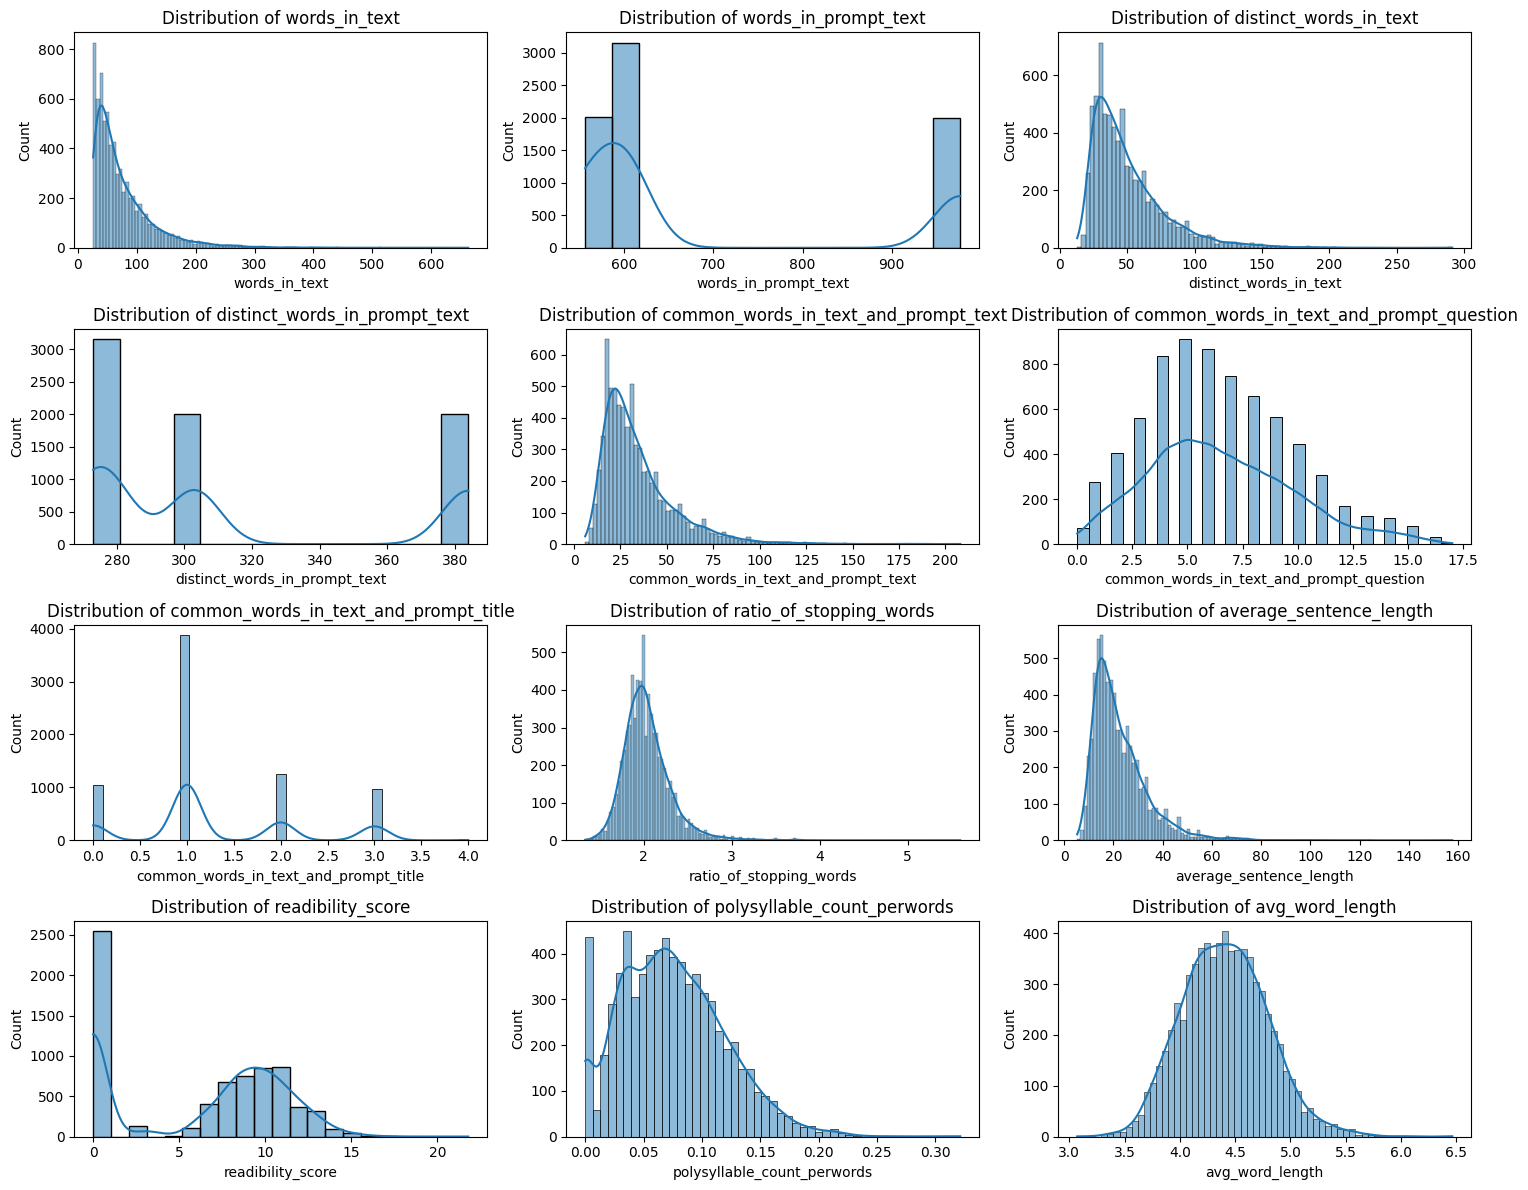

In [28]:

features_to_visualize = ["words_in_text", "words_in_prompt_text", "distinct_words_in_text",
                         "distinct_words_in_prompt_text", "common_words_in_text_and_prompt_text",
                         "common_words_in_text_and_prompt_question", "common_words_in_text_and_prompt_title",
                         "ratio_of_stopping_words", "average_sentence_length", "readibility_score",
                         "polysyllable_count_perwords", "avg_word_length"]

# Set the number of subplots per row and column
num_rows = 4
num_cols = 3

# Create a figure with subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 12))
fig.subplots_adjust(hspace=0.5)

# Plot histograms for each feature
for i, feature in enumerate(features_to_visualize):
    row = i // num_cols
    col = i % num_cols

    # Plot histogram using Seaborn
    sns.histplot(plot_df[feature], ax=axes[row, col], kde=True)
    axes[row, col].set_title(f'Distribution of {feature}')

# Adjust the layout
plt.tight_layout()

# Show the plots
plt.show()


This plot shows the distribution of all the features.

I can infer that, we need to scale the features and use models that are good at handling non-linear features for better results since most of the features are non linear in nature.

# Plot 2

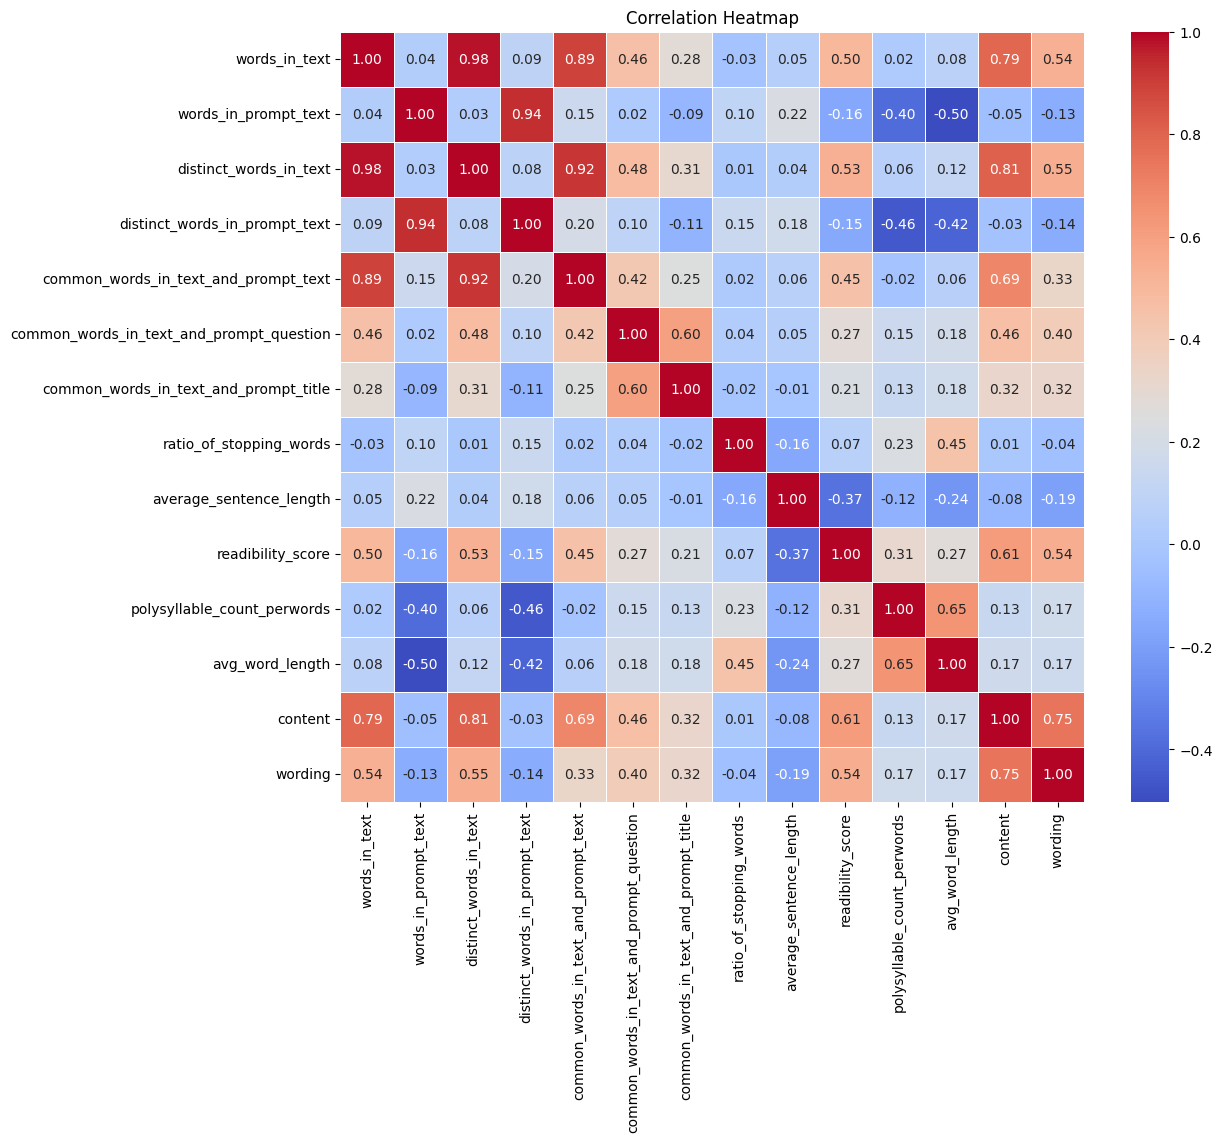

In [29]:
selected_features = ["words_in_text", "words_in_prompt_text", "distinct_words_in_text",
                     "distinct_words_in_prompt_text", "common_words_in_text_and_prompt_text",
                     "common_words_in_text_and_prompt_question", "common_words_in_text_and_prompt_title",
                     "ratio_of_stopping_words", "average_sentence_length", "readibility_score",
                     "polysyllable_count_perwords", "avg_word_length"]
data_for_correlation = plot_df[selected_features + ["content", "wording"]]

# Calculate the correlation matrix
correlation_matrix = data_for_correlation.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create a heatmap using Seaborn
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5, fmt=".2f")

# Set plot title
plt.title("Correlation Heatmap")

# Show the plot
plt.show()

This is a plot for the correlation matrix for all the features.

We can estimate the importance of each feature and their correlation with each other and the content and wording scores.

Another thing to note is the negetive corr between words in text and the average word length and, how word length has weak correlation with both wording and content scores.

## **Section 6: Baseline Model (Q7, 10 points)**

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


# Define features (X) and target (y) for the "content" model
X_content = merged_train[["words_in_text", "words_in_prompt_text", "distinct_words_in_text", "distinct_words_in_prompt_text",
                          "common_words_in_text_and_prompt_text", "common_words_in_text_and_prompt_question",
                          "common_words_in_text_and_prompt_title"]]
y_content = merged_train["content"]

# Define features (X) and target (y) for the "wording" model
X_wording = merged_train[["words_in_text", "words_in_prompt_text", "distinct_words_in_text", "distinct_words_in_prompt_text",
                          "common_words_in_text_and_prompt_text", "common_words_in_text_and_prompt_question",
                          "common_words_in_text_and_prompt_title"]]
y_wording = merged_train["wording"]

# Split the data into training and testing sets (80% training, 20% testing)
X_content_train, X_content_test, y_content_train, y_content_test = train_test_split(X_content, y_content, test_size=0.2, random_state=42)
X_wording_train, X_wording_test, y_wording_train, y_wording_test = train_test_split(X_wording, y_wording, test_size=0.2, random_state=42)

# Initialize Linear Regression models
content_model = LinearRegression()
wording_model = LinearRegression()

# Train the models
content_model.fit(X_content_train, y_content_train)
wording_model.fit(X_wording_train, y_wording_train)

# Make predictions on the test set
content_predictions = content_model.predict(X_content_test)
wording_predictions = wording_model.predict(X_wording_test)

# Calculate mean squared error for each model
content_mse = mean_squared_error(y_content_test, content_predictions)
wording_mse = mean_squared_error(y_wording_test, wording_predictions)

# Print the mean squared error for each model
print("Mean Squared Error for Content Model:", content_mse)
print("Mean Squared Error for Wording Model:", wording_mse)


Mean Squared Error for Content Model: 0.35228533880829715
Mean Squared Error for Wording Model: 0.514306909289029


## **Section 7: Feature Cleaning and Additional Models (Q8 & Q9, 20 points total)**

# Merged_train2 is a copy of the original dataframe, merged_train and I will do all the preprocessing and cleaning on this copy.

In [31]:
merged_train2 = merged_train.copy()
from nltk.stem import WordNetLemmatizer
nltk.download("wordnet")

# Initialize the WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# Define a function to lemmatize a given text
def lemmatize_text(text):
    # Tokenize the text into words
    words = nltk.word_tokenize(text.lower())

    # Lemmatize each word and join them back into a text
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]

    return " ".join(lemmatized_words)

# Apply the lemmatization function to the text columns in DataFrame
merged_train2["text"] = merged_train2["text"].apply(lemmatize_text)
merged_train2["prompt_text"] = merged_train2["prompt_text"].apply(lemmatize_text)
merged_train2["prompt_question"] = merged_train2["prompt_question"].apply(lemmatize_text)
merged_train2["prompt_title"] = merged_train2["prompt_title"].apply(lemmatize_text)

# Define a function to remove stop words from a text
stop_words = set(stopwords.words("english"))
def remove_stopwords(text):
    words = text.split()  # Split the text into words
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return " ".join(filtered_words)

# Apply the remove_stopwords function to the text columns
merged_train2['text'] = merged_train2['text'].apply(remove_stopwords)
merged_train2['prompt_text'] = merged_train2['prompt_text'].apply(remove_stopwords)
merged_train2['prompt_title'] = merged_train2['prompt_title'].apply(remove_stopwords)

merged_train2.head()


[nltk_data] Downloading package wordnet to /root/nltk_data...


,student_id,prompt_id,text,content,wording,prompt_question,prompt_title,prompt_text,words_in_text,words_in_prompt_text,distinct_words_in_text,distinct_words_in_prompt_text,common_words_in_text_and_prompt_text,common_words_in_text_and_prompt_question,common_words_in_text_and_prompt_title,ratio_of_stopping_words,average_sentence_length,readibility_score,polysyllable_count_perwords,avg_word_length
0,000e8c3c7ddb,814d6b,third wave wa experimentto see people reacted ...,0.205683,0.380538,summarize how the third wave developed over su...,third wave,background third wave experiment took place cu...,61,601,51,280,24,7,3,2.440000,15.250000,10.7,0.114754,4.639344
1,0020ae56ffbf,ebad26,would rub soda make smell go away wouldnt bad ...,-0.548304,0.506755,summarize the various way the factory would us...,excerpt jungle,"one member trimming beef cannery , another wor...",52,977,36,384,33,5,1,1.677419,26.000000,0.0,0.000000,3.673077
2,004e978e639e,3b9047,"egypt , many occupation social class involved ...",3.128928,4.231226,"in complete sentence , summarize the structure...",egyptian social structure,egyptian society wa structured like pyramid . ...,239,556,146,303,81,10,1,2.276190,19.916667,9.3,0.058577,4.594142
3,005ab0199905,3b9047,highest class wa pharaoh people gods.then 2nd ...,-0.210614,-0.471415,"in complete sentence , summarize the structure...",egyptian social structure,egyptian society wa structured like pyramid . ...,28,556,22,303,15,2,0,2.333333,9.333333,9.7,0.142857,4.535714
4,0070c9e7af47,814d6b,third wave developed rapidly student genuinly ...,3.272894,3.219757,summarize how the third wave developed over su...,third wave,background third wave experiment took place cu...,205,601,133,280,53,10,3,2.135417,14.642857,10.1,0.102439,4.829268


In [32]:
# Model1_df has all the  features required to train the model

model1_df = pd.DataFrame()

model1_df["words_in_text"] = merged_train2.apply(lambda x: countofwords(x['text']), axis = 1)
model1_df["words_in_prompt_text"] = merged_train2.apply(lambda x: countofwords(x['prompt_text']), axis = 1)
model1_df["distinct_words_in_text"] = merged_train2.apply(lambda x: distinctwords(x['text']), axis = 1)
model1_df["distinct_words_in_prompt_text"] = merged_train2.apply(lambda x: distinctwords(x['prompt_text']), axis = 1)
model1_df["common_words_in_text_and_prompt_text"] = merged_train2.apply(lambda x: commonwords(x['text'],x['prompt_text']), axis = 1)
model1_df["common_words_in_text_and_prompt_question"] = merged_train2.apply(lambda x: commonwords(x['text'],x['prompt_question']), axis = 1)
model1_df["common_words_in_text_and_prompt_title"] = merged_train2.apply(lambda x: commonwords(x['text'],x['prompt_title']), axis = 1)
# I have used the cleaned dataframe, Merged_train2 for the original features. for my features, I qould like to use the original dataset, hence i will use join fuction
# to join the features to our model1 dataframe.
model1_df = model1_df.join(merged_train["ratio_of_stopping_words"])
model1_df = model1_df.join(merged_train["average_sentence_length"])
model1_df = model1_df.join(merged_train["readibility_score"])
model1_df = model1_df.join(merged_train["polysyllable_count_perwords"])
model1_df = model1_df.join(merged_train["avg_word_length"])
model1_df["content"] = merged_train["content"]
model1_df["wording"] = merged_train["wording"]
model1_df.head()

,words_in_text,words_in_prompt_text,distinct_words_in_text,distinct_words_in_prompt_text,common_words_in_text_and_prompt_text,common_words_in_text_and_prompt_question,common_words_in_text_and_prompt_title,ratio_of_stopping_words,average_sentence_length,readibility_score,polysyllable_count_perwords,avg_word_length,content,wording
0,37,316,33,207,10,3,2,2.440000,15.250000,10.7,0.114754,4.639344,0.205683,0.380538
1,22,476,17,298,15,2,0,1.677419,26.000000,0.0,0.000000,3.673077,-0.548304,0.506755
2,139,322,104,230,59,4,1,2.276190,19.916667,9.3,0.058577,4.594142,3.128928,4.231226
3,19,322,16,230,8,1,0,2.333333,9.333333,9.7,0.142857,4.535714,-0.210614,-0.471415
4,114,316,89,207,27,6,2,2.135417,14.642857,10.1,0.102439,4.829268,3.272894,3.219757


# Model 01 after cleaning data and normalizing the initial parametres.

In [33]:

from sklearn.preprocessing import StandardScaler




# Define the features (X) and target (y)
X = model1_df[["words_in_text", "words_in_prompt_text", "distinct_words_in_text",
                  "distinct_words_in_prompt_text", "common_words_in_text_and_prompt_text",
                  "common_words_in_text_and_prompt_question", "common_words_in_text_and_prompt_title",
               "ratio_of_stopping_words","average_sentence_length","readibility_score",
               "polysyllable_count_perwords", "avg_word_length"]]
y_content = model1_df["content"]
y_wording = model1_df["wording"]

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_content_train, y_content_test, y_wording_train, y_wording_test = train_test_split(
    X, y_content, y_wording, test_size=0.2, random_state=42
)

# Normalize the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and train the content model
content_model = LinearRegression()
content_model.fit(X_train_scaled, y_content_train)

# Create and train the wording model
wording_model = LinearRegression()
wording_model.fit(X_train_scaled, y_wording_train)

# Predict the target values on the test set for both models
content_predictions = content_model.predict(X_test_scaled)
wording_predictions = wording_model.predict(X_test_scaled)

# Calculate mean squared error for both models
content_mse = mean_squared_error(y_content_test, content_predictions)
wording_mse = mean_squared_error(y_wording_test, wording_predictions)

# Print the mean squared error for each model
print("Content Model Mean Squared Error:", content_mse)
print("Wording Model Mean Squared Error:", wording_mse)


Content Model Mean Squared Error: 0.29830460003582926
Wording Model Mean Squared Error: 0.42447537126664836


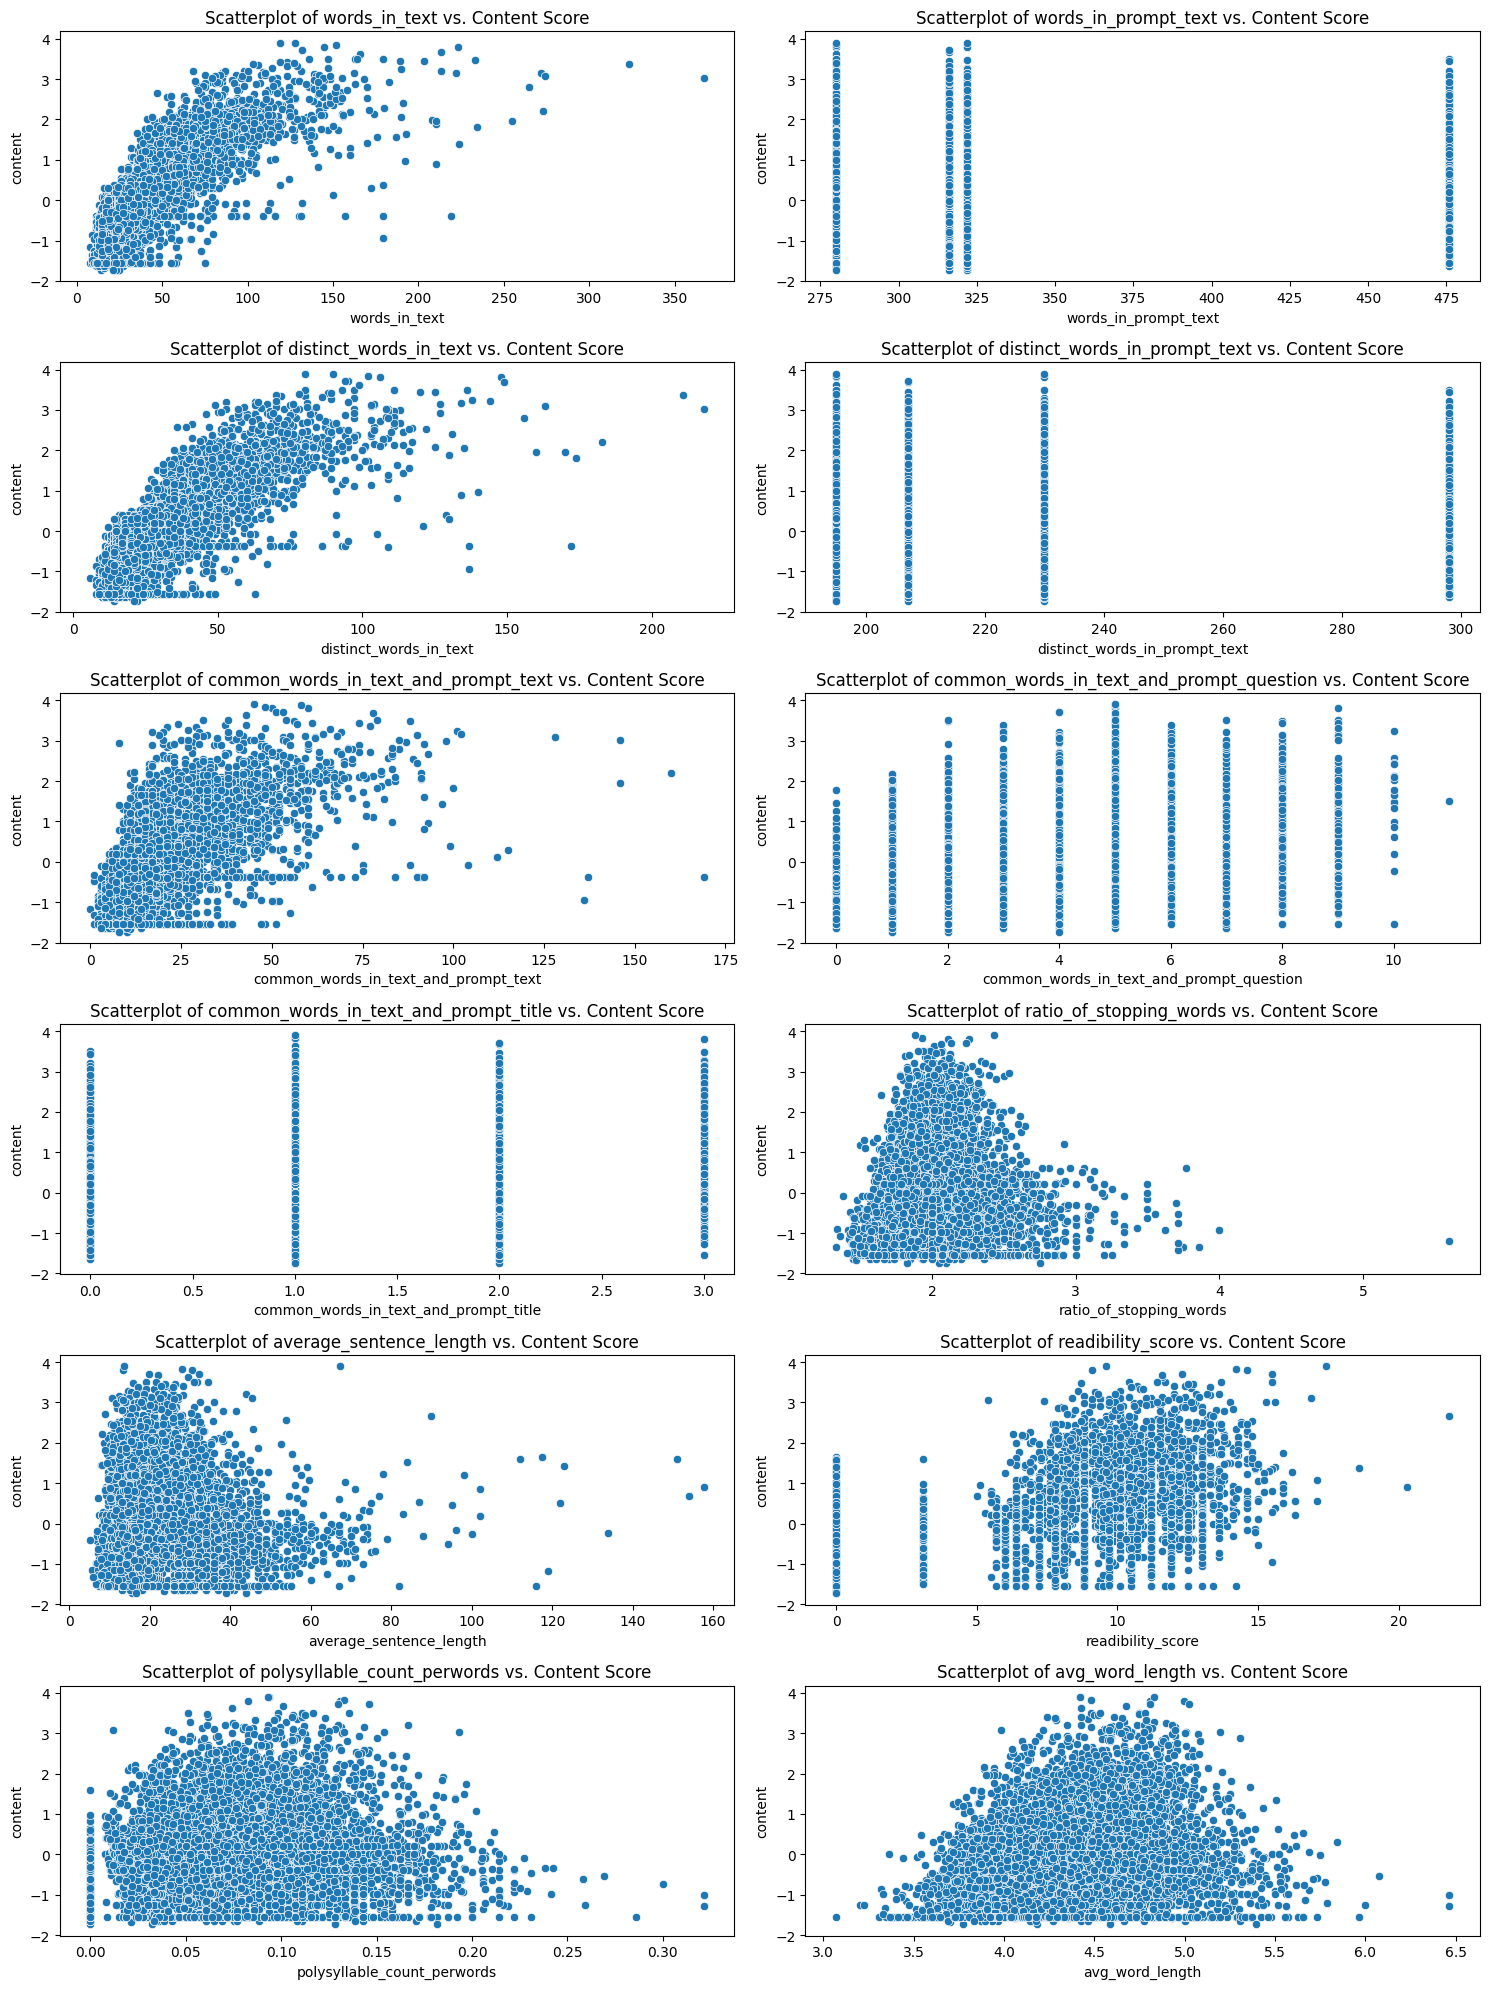

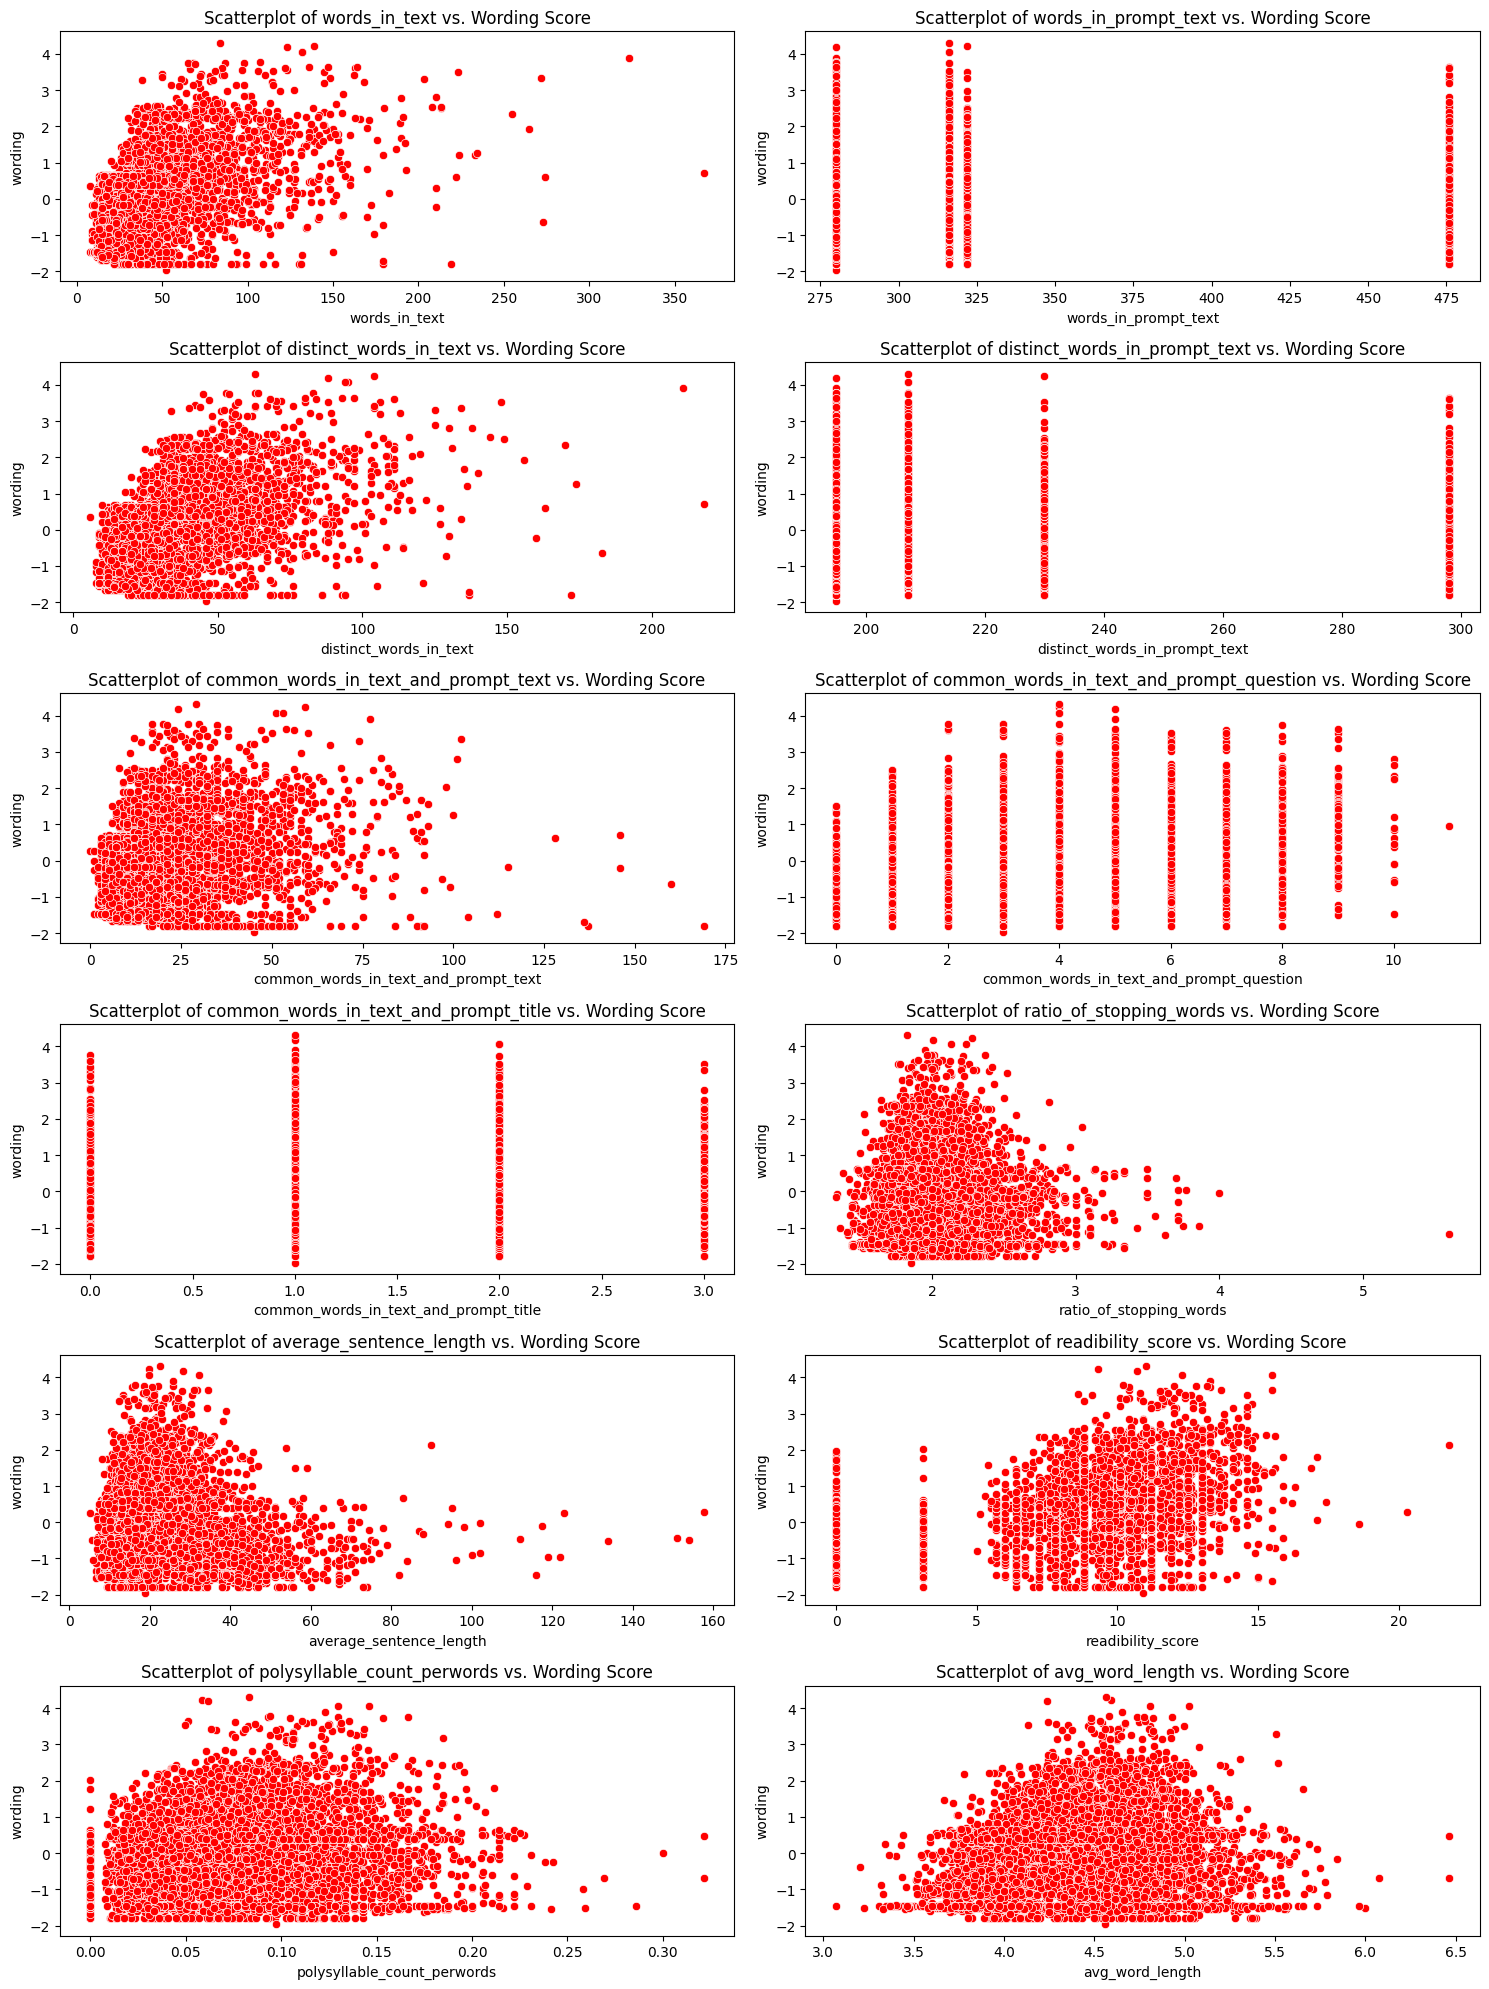

In [34]:


# Extract features and target variables from the DataFrame
features = ["words_in_text", "words_in_prompt_text", "distinct_words_in_text",
            "distinct_words_in_prompt_text", "common_words_in_text_and_prompt_text",
            "common_words_in_text_and_prompt_question", "common_words_in_text_and_prompt_title",
            "ratio_of_stopping_words","average_sentence_length","readibility_score",
            "polysyllable_count_perwords", "avg_word_length"]
content_scores = model1_df["content"]
wording_scores = model1_df["wording"]

# Create scatterplots for each feature vs. content score
plt.figure(figsize=(15, 20))
for i, feature in enumerate(features, 1):
    plt.subplot(6, 2, i)
    sns.scatterplot(data=model1_df, x=feature, y="content")
    plt.title(f"Scatterplot of {feature} vs. Content Score")

plt.tight_layout()
plt.show()

# Create scatterplots for each feature vs. wording score
plt.figure(figsize=(15, 20))
for i, feature in enumerate(features, 1):
    plt.subplot(6, 2, i)
    sns.scatterplot(data=model1_df, x=feature, y="wording", color="red")
    plt.title(f"Scatterplot of {feature} vs. Wording Score")

plt.tight_layout()
plt.show()


I have decided to try and use SVM first with a "RBF" kernel since SVM models with rbf kernels are good at handling non linear data that is clustered. I have plotted the scatterplot to know the distribution of the data to reach this conclusion.


In [35]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

# Separate the data into content and wording scores
X = model1_df[["words_in_text", "words_in_prompt_text", "distinct_words_in_text",
                  "distinct_words_in_prompt_text", "common_words_in_text_and_prompt_text",
                  "common_words_in_text_and_prompt_question", "common_words_in_text_and_prompt_title",
               "ratio_of_stopping_words","average_sentence_length","readibility_score",
               "polysyllable_count_perwords", "avg_word_length"]]
content_scores = model1_df["content"]
wording_scores = model1_df["wording"]

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, content_train, content_test, wording_train, wording_test = train_test_split(
    X, content_scores, wording_scores, test_size=0.2, random_state=42)

# Create separate SVM models for content and wording scores
content_svm = SVR(kernel='rbf')
wording_svm = SVR(kernel='rbf')

# Train the SVM models
content_svm.fit(X_train, content_train)
wording_svm.fit(X_train, wording_train)

# Make predictions on the test set
content_predictions = content_svm.predict(X_test)
wording_predictions = wording_svm.predict(X_test)

# Evaluate the models
content_mse = mean_squared_error(content_test, content_predictions)


wording_mse = mean_squared_error(wording_test, wording_predictions)


print("Content Score Prediction Results:")
print(f"Mean Squared Error (MSE): {content_mse}")


print("\nWording Score Prediction Results:")
print(f"Mean Squared Error (MSE): {wording_mse}")



Content Score Prediction Results:
Mean Squared Error (MSE): 0.24913744590539605

Wording Score Prediction Results:
Mean Squared Error (MSE): 0.40991833751239426


# Why I have decided to use random forest instead.

I have decided for use Random forest instead is because they handle high dimentionality data with multicollinearity better than SVM models with a radial bias kernel. Random forest models are also less prone to overfitting as they are ensemble models. Apart from that, they are better at regression tasks.

In [36]:
# Import necessary libraries

from sklearn.ensemble import RandomForestRegressor


# Split the dataset into features (X) and target variables (y)
X = model1_df[["words_in_text", "words_in_prompt_text", "distinct_words_in_text",
               "distinct_words_in_prompt_text", "common_words_in_text_and_prompt_text",
               "common_words_in_text_and_prompt_question", "common_words_in_text_and_prompt_title",
               "ratio_of_stopping_words","average_sentence_length","readibility_score",
               "polysyllable_count_perwords", "avg_word_length"]]
y_content = model1_df["content"]
y_wording = model1_df["wording"]

# Split the data into training and testing sets
X_train, X_test, y_content_train, y_content_test, y_wording_train, y_wording_test = train_test_split(
    X, y_content, y_wording, test_size=0.2, random_state=42
)

# Create and train the Random Forest model for content score prediction
content_rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
content_rf_model.fit(X_train, y_content_train)

# Create and train the Random Forest model for wording score prediction
wording_rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
wording_rf_model.fit(X_train, y_wording_train)

# Make predictions using the trained models
content_predictions = content_rf_model.predict(X_test)
wording_predictions = wording_rf_model.predict(X_test)

# Calculate mean squared errors for content and wording predictions
content_mse = mean_squared_error(y_content_test, content_predictions)
wording_mse = mean_squared_error(y_wording_test, wording_predictions)

# Print the mean squared errors
print("Mean Squared Error for Content Score:", content_mse)
print("Mean Squared Error for Wording Score:", wording_mse)


Mean Squared Error for Content Score: 0.21803365207236863
Mean Squared Error for Wording Score: 0.3863001219427972


# Q5 Part3: Feature Importance plot for Content and Wordings

I have plotted the feature importance plot to know how much each feature affects the wording and content scores.

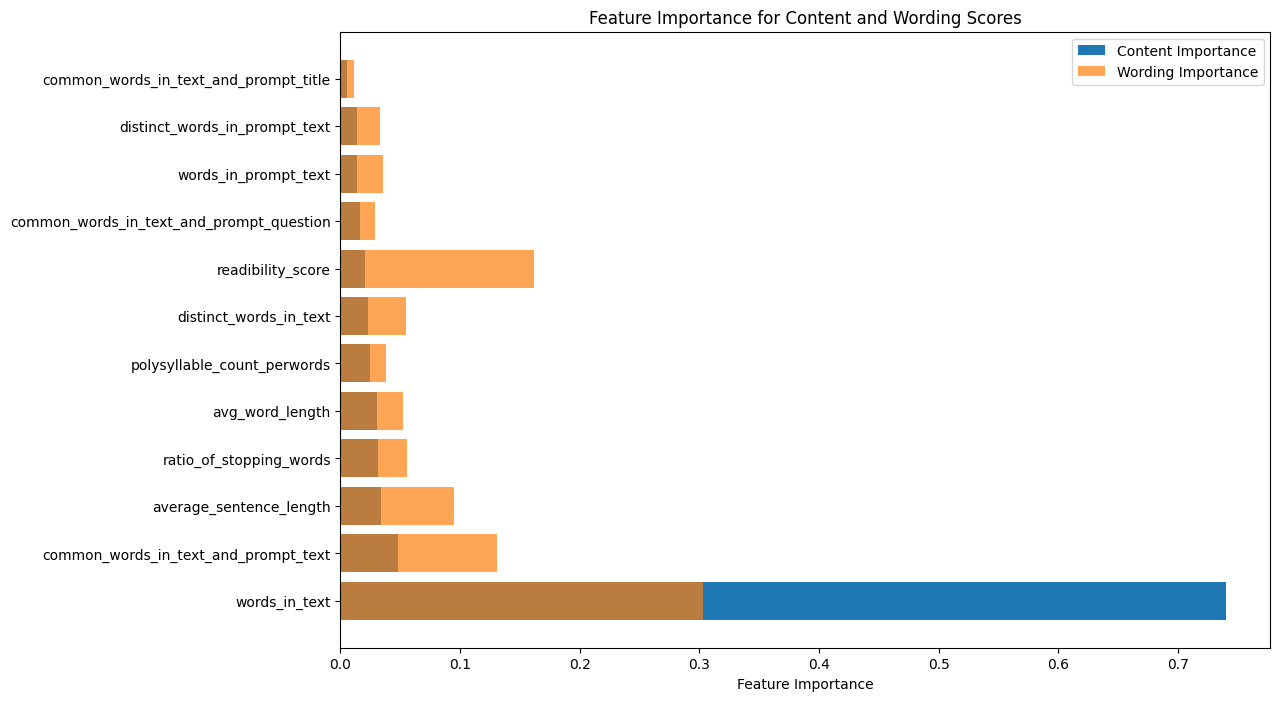

In [37]:
content_feature_importances = content_rf_model.feature_importances_
wording_feature_importances = wording_rf_model.feature_importances_


feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Content_Importance': content_feature_importances,
    'Wording_Importance': wording_feature_importances,
})

# Sort features by importance for both content and wording
feature_importance_df = feature_importance_df.sort_values(by=['Content_Importance', 'Wording_Importance'], ascending=False)

# Create feature importance plots
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Content_Importance'], label='Content Importance')
plt.barh(feature_importance_df['Feature'], feature_importance_df['Wording_Importance'], alpha=0.7, label='Wording Importance')
plt.xlabel('Feature Importance')
plt.title('Feature Importance for Content and Wording Scores')
plt.legend()
plt.show()

## **Section 8: Kaggle Submission Screenshots (Q10, 5 points)**

Public Score:

Private Score:

Kaggle profile link:

Screenshot(s):